In [317]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image, ImageFilter
import math
from os import listdir
import random
import cv2

import pywt

import keras
from keras import backend as K
from keras.models import model_from_json
from keras.models import Model, Sequential
from keras.layers import Input, Convolution2D, Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Conv2D, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD, Adam
from keras import regularizers, optimizers, losses, initializers

import tensorflow as tf
from tensorflow.python.client import device_lib

In [318]:
%run srcnn.py

In [319]:
print(device_lib.list_local_devices())
print(K.tensorflow_backend._get_available_gpus())

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1
session = tf.Session(config=config)
keras.backend.set_session(session)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5134691436202719266
]
[]


### Load images

In [320]:
PATH = "../"
TRAIN_FILE = PATH + "datasets/DIV2K_train_HR/"
TEST_FILE = PATH +"datasets/DIV2K_train_LR_wild/"
VALID_HR = PATH +"datasets/DIV2K_valid_HR/"
VALID_LR = PATH +"datasets/DIV2K_valid_LR_wild/"
obj_files = listdir(TRAIN_FILE )
valid_files = listdir(VALID_HR )

In [321]:
valid_files[:5]

['0897.png', '0887.png', '0806.png', '0834.png', '0896.png']

In [322]:
def convertToYCbCr(x):
    return [image.convert('YCbCr') for image in x]

In [323]:
#Load images

obj_img = []
train_img = []
valid_hr_img = []
valid_lr_img= []

for i in range(0,64): #should be replaced here with something random at some point
    n = obj_files[i]
    m = valid_files[i]
    obj_img.append(Image.open(TRAIN_FILE + n))
    train_img.append(Image.open(TEST_FILE + n[:-4]+"x4w1.png"))
    
    valid_hr_img.append(Image.open(VALID_HR +  m))
    valid_lr_img.append(Image.open(VALID_LR + m[:-4]+"x4w.png"))
#Only consider the luminance channel (YCrCb)
ycbcr_obj = convertToYCbCr(obj_img)
ycbcr_train = convertToYCbCr(train_img)
ycbr_valid_hr = convertToYCbCr(valid_hr_img)
ycbr_valid_lr = convertToYCbCr(valid_lr_img)

In [324]:
ycbcr_obj[0].size

(2040, 1140)

In [325]:
#Display images
def print_luminance(img, ch=1) :
    if (ch == 1) :
        plt.imshow(img, cmap=plt.get_cmap('gray'), interpolation='nearest')
    else :
        plt.imshow(img[:,:,0], cmap=plt.get_cmap('gray'), interpolation='nearest')

In [326]:
#Convert images to numpy array
imgs_label = [np.asarray(image)[:,:,0] for image in ycbcr_obj]
imgs_train = [np.asarray(image)[:,:,0] for image in ycbcr_train]
imgs_valid_hr = [np.asarray(image)[:,:,0] for image in ycbr_valid_hr]
imgs_valid_lr = [np.asarray(image)[:,:,0] for image in ycbr_valid_lr]


In [327]:
imgs_label[0].shape

(1140, 2040)

(1368, 2040)


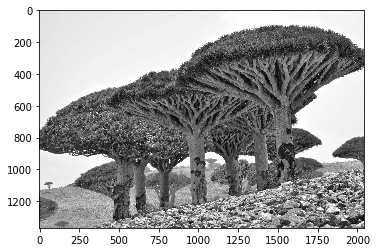

In [328]:
print(imgs_label[1].shape)
print_luminance(imgs_label[1])

(342, 510)


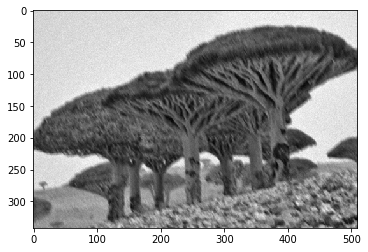

In [329]:
print(imgs_train[1].shape)
print_luminance(imgs_train[1])

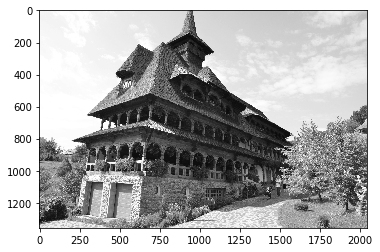

In [330]:
print_luminance(imgs_valid_hr[3])

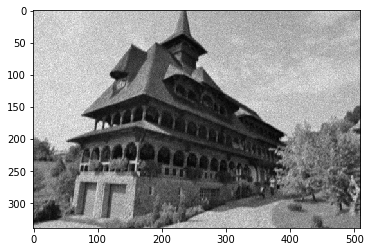

In [331]:
print_luminance(imgs_valid_lr[3])

### Generate train and test set

In [332]:
def getSubImage(img, height, width, centerX, centerY, len_interval, scale = 1) :
    window = window_size // scale
    return img[ height   : height//2 + window + centerX*len_interval,
                width // 2  + centerY*len_interval : width//2 + window + centerY*len_interval : ]

In [333]:
def retSize(x):
    return (x.shape[0], x.shape[1])

In [334]:
#Division by 4
window_size= 64
scale = 4
stride = 60
subimages_per_axis = 4

In [335]:
def getSubImages(image, stride = stride) :
    sub = []
    height, width = retSize(image)
    for h in range(0, height - window_size, stride) :
        for w in range (0, width - window_size, stride) : 
            sub.append(image[h : h + window_size, w : w + window_size])
    return sub

In [336]:
sub_labels = []
sub_samples = []
sub_valid_hr = []
sub_valid_lr = []

for i in range(0,50) :
    label = imgs_label[i]
    shape = imgs_train[i].shape
    s = cv2.resize(imgs_train[i], dsize = (shape[1]*4, shape[0]*4), interpolation = cv2.INTER_CUBIC)
    
    valid_hr = imgs_valid_hr[i]
    shape_lr = imgs_valid_lr[i].shape
    valid_lr = cv2.resize(imgs_valid_lr[i], dsize = (shape_lr[1]*4, shape_lr[0]*4), interpolation = cv2.INTER_CUBIC)
    
    #height_label, width_label = retSize(label)
    #height_sample, width_sample = retSize(s)
    #height_hr, width_hr = retSize(valid_hr)
    #height_vlr, width_vlr = retSize(valid_lr)
    
    len_interval = height_sample//subimages_per_axis
    
    #Calculate subimages
    sub_labels += getSubImages(label)
    sub_samples += getSubImages(s)
    sub_valid_hr += getSubImages(valid_hr)
    sub_valid_lr += getSubImages(valid_lr)

In [337]:
len(sub_labels)

36300

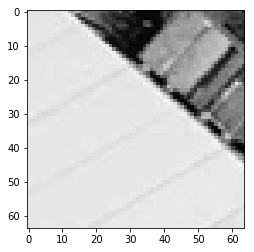

In [338]:
print_luminance(sub_labels[0])

(64, 64)

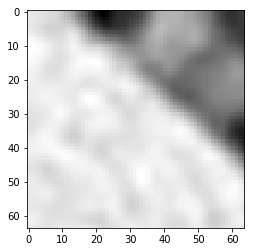

In [339]:
print_luminance(sub_samples[0])
sub_samples[1].shape

(64, 64)

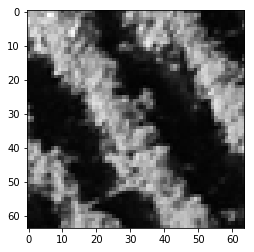

In [340]:
print_luminance(sub_valid_hr[7])
sub_valid_hr[1].shape

(64, 64)

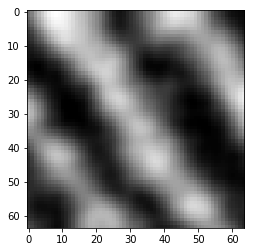

In [341]:
print_luminance(sub_valid_lr[7])
sub_valid_lr[1].shape

#### Generate the wavelets subbands

In [342]:
def appendSubbands(l1,l2,l3,l4, dwt):
    l1 = np.append(l1 , dwt[0])
    l2 = np.append(l2, dwt[1][0])
    l3 = np.append(l3, dwt[1][1])
    l4 = np.append(l4, dwt[1][2])
    return (l1,l2,l3,l4)

In [343]:
def plot4images(im1, im2, im3, im4, ch=1) :
    fig = plt.figure(figsize=(10, 10))
    
    plt.subplot(221)
    plt.title("Average")
    print_luminance(im1, ch )
    plt.subplot(222)
    print_luminance(im2, ch)
    plt.subplot(223)
    print_luminance(im3, ch)
    plt.subplot(224)
    print_luminance(im4, ch)

def plot_waveletTrans(wt, ch=1) :
    plot4images(wt[0], wt[1][0], wt[1][1], wt[1][2], ch)

(32, 32)


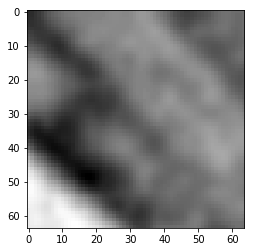

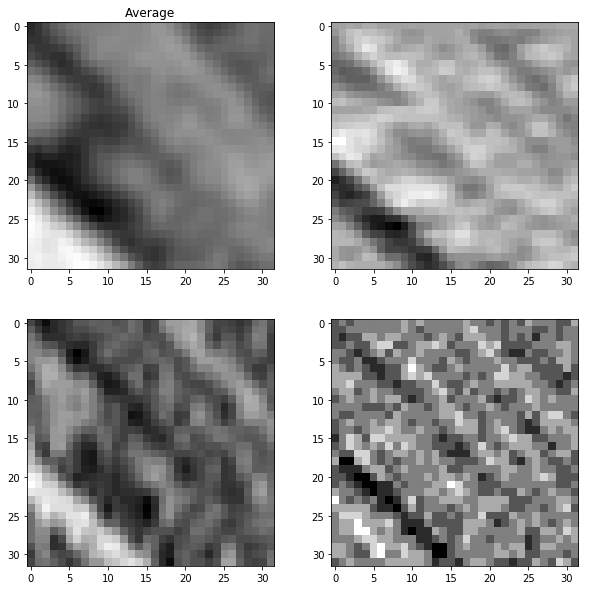

In [344]:
x_sample = sub_samples[1]
print_luminance(x_sample)
x_dwt = pywt.dwt2(x_sample, 'haar')
print(x_dwt[0].shape)
plot_waveletTrans(x_dwt)

422.00000000000006


numpy.ndarray

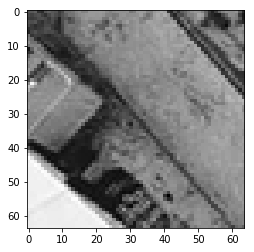

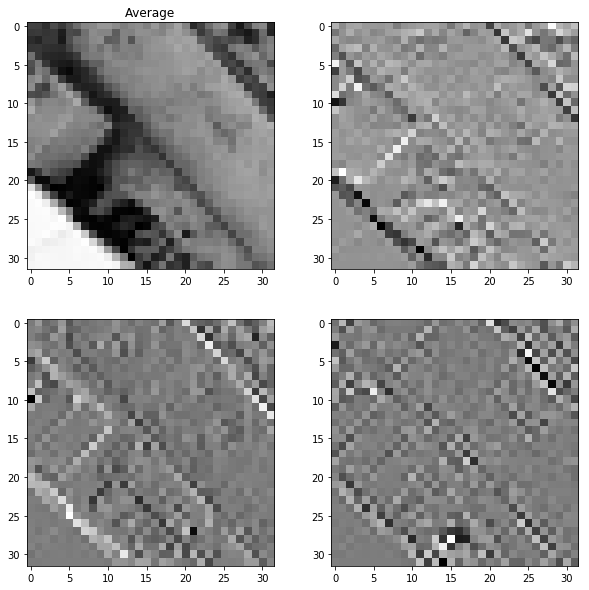

In [345]:
y_sample = sub_labels[1]
print_luminance(y_sample)
y_dwt = pywt.dwt2(y_sample, 'haar')
print(y_dwt[0].max())
plot_waveletTrans(y_dwt)
type(y_dwt[1][1])

In [346]:
pepe = np.asfarray([y_dwt[0], y_dwt[1][0], y_dwt[1][1], y_dwt[1][2]])
pepe.max()

422.00000000000006

In [347]:
shape = 32

test_list = []
train_list = []
for i in range(len(sub_labels)):
    y = sub_labels[i]
    x = sub_samples[i]
    vy = sub_valid_hr[i]
    vx = sub_valid_lr[i]
    
    dwt_y = pywt.dwt2(y, 'haar')
    dwt_x = pywt.dwt2(x, 'haar')    
    
    
    hight = np.asfarray([dwt_y[0], dwt_y[1][0], dwt_y[1][1], dwt_y[1][2]])
    x = np.asfarray([dwt_x[0], dwt_x[1][0], dwt_x[1][1], dwt_x[1][2]])
    
    y = hight - x
    
    test_list.append(y)
    train_list.append(x)

In [348]:
t = test_list[10] == train_list[10]

In [349]:
def equals(a, b) :
    t = a == b
    count = 0
    for a in range(0, len(t)) :
        for b in range(len(t[0])) :
            for c in range(len(t[1])) :
                if ( t[a, b, c] == False):
                    count = count + 1
    return count / (32*32*4) < 0.50
    

In [350]:
len(test_list)

36300

In [351]:
max_ = 0
for i in range(len(test_list)) :
    tmp = test_list[i].max()
    if (tmp > max_ ) :
        max_ = tmp
max_

482.5000000000001

In [352]:
test = np.asarray(test_list)
train = np.asarray(train_list)

#print(test.max())

#test = test / 255.
#train = test / 255.

In [353]:
equals(test_list[0], train_list[0])

False

In [354]:
test.shape

(36300, 4, 32, 32)

In [355]:
equals(train[10], test[10])

False

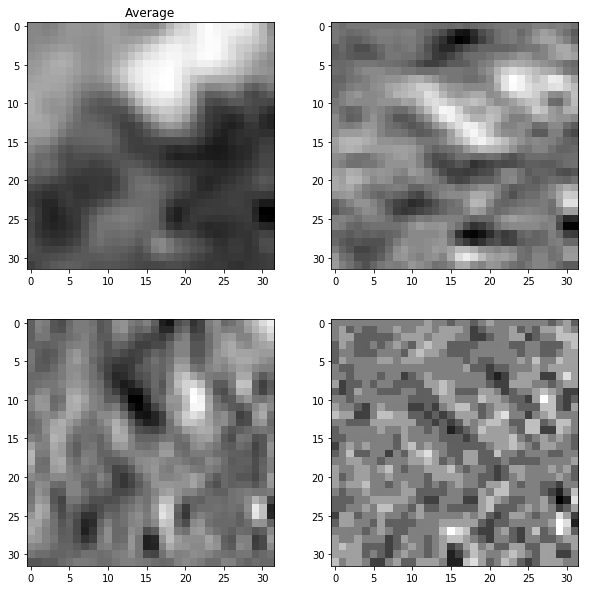

In [356]:
sample = train[10]
plot4images(sample[0], sample[1], sample[2], sample[3])

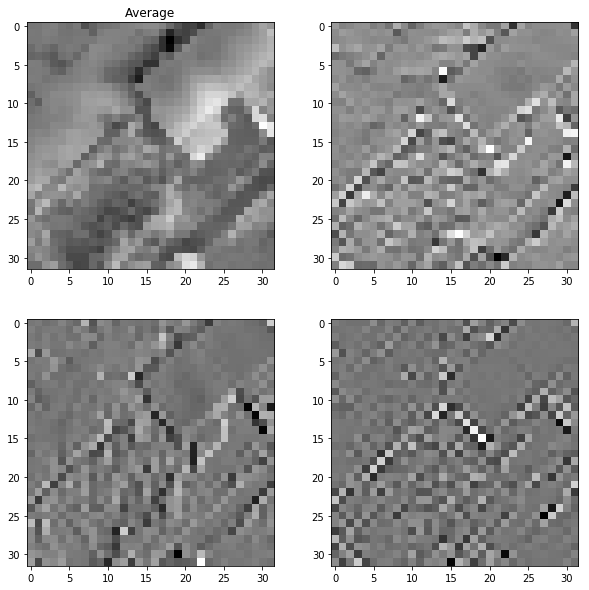

In [357]:
label = test[10]
plot4images(label[0], label[1], label[2], label[3])

#### Creating and Training the networks

In [358]:
def reshape(matrix, dwt_shape, channel='channels_last', ch=1) :
    if (channel == 'channels_last') :
        return matrix.reshape(-1, dwt_shape[0], dwt_shape[1], ch)
    else :
        return matrix.reshape(ch, -1, dwt_shape[0], dwt_shape[1])

In [359]:
input_shape = train.shape
input_shape

(36300, 4, 32, 32)

In [360]:
kernel_ini = initializers.RandomNormal(mean=0.0, stddev=1e-3, seed=None)
bias_ini = keras.initializers.Zeros()

adam = optimizers.Adam() 

In [367]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(5,5),strides=(1,1),padding='same',
                 activation='selu',
                 input_shape=(4, shape, shape),
                 kernel_initializer=kernel_ini,
                 bias_initializer=bias_ini,
                 data_format='channels_first'))
for i in range(10) :
    model.add(Conv2D(64, (3, 3),strides=(1,1), activation='selu', padding='same', kernel_initializer=kernel_ini,
                 bias_initializer=bias_ini, data_format='channels_first'))

    
model.add(Conv2D(1, (3, 3),strides=(1,1), padding='same', kernel_initializer=kernel_ini,
                 bias_initializer=bias_ini, data_format='channels_first'))

model.compile(optimizer=Adam(),
             loss='mean_squared_error')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 64, 32, 32)        6464      
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 64, 32, 32)        36928     
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 64, 32, 32)        36928     
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 64, 32, 32)        36928     
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 64, 32, 32)        36928     
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 64, 32, 32)        36928     
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 64, 32, 32)        36928     
__________

In [364]:
history_CNN = model.fit(train, test, validation_split=0.2, epochs=50, batch_size=64, verbose=1)

Train on 29040 samples, validate on 7260 samples
Epoch 1/50
29040/29040 [==============================] - 1654s 57ms/step - loss: 835.3119 - val_loss: 936.8972
Epoch 2/50
29040/29040 [==============================] - 1660s 57ms/step - loss: 787.8223 - val_loss: 890.0016
Epoch 3/50
29040/29040 [==============================] - 1658s 57ms/step - loss: 782.9514 - val_loss: 921.4490
Epoch 4/50
29040/29040 [==============================] - 1664s 57ms/step - loss: 778.6219 - val_loss: 940.0482
Epoch 5/50
29040/29040 [==============================] - 1664s 57ms/step - loss: 776.2583 - val_loss: 946.1948
Epoch 6/50
29040/29040 [==============================] - 1661s 57ms/step - loss: 774.0574 - val_loss: 960.4818
Epoch 7/50
29040/29040 [==============================] - 1660s 57ms/step - loss: 770.2758 - val_loss: 908.1862
Epoch 8/50
29040/29040 [==============================] - 1663s 57ms/step - loss: 768.7999 - val_loss: 912.2505
Epoch 9/50
29040/29040 [==============================]

KeyboardInterrupt: 

#### Original image and bicubic interpolated image

In [185]:
def patch_to_image(patches, height, width) :
    count = 0
    img = np.zeros((height, width))
    for h in range(0, height - window_size, stride) :
        for w in range (0, width - window_size, stride) : 
            img[h : h + window_size, w : w + window_size] = patches[count]
            count = count + 1
    return img

In [226]:
PRED_FILE = PATH + "datasets/DIV2K_test_LR_wild/0901x4w.png"
im = Image.open(PRED_FILE)

img = np.asarray(im.convert('YCbCr'))
img = img[:,:,0]
img.shape
h, w = retSize(img)
img.shape
#img = np.asarray(convertToYCbCr([im]))

(339, 510)

In [227]:
sub_img = getSubImages(img)

t.shape

(23, 23)

In [228]:
pred_list = []
for i in range(len(sub_img)):
    wavlets = sub_img[i]
    
    dwt_w = pywt.dwt2(wavlets, 'haar')
    
    low = np.asfarray([dwt_w[0], dwt_w[1][0], dwt_w[1][1], dwt_w[1][2]])
    
    pred_list.append(low)


In [229]:
pred_imgs = np.asarray(pred_list)
pred_imgs.shape

(40, 4, 32, 32)

In [230]:
wv = model.predict(pred_imgs)

In [231]:
w

510

In [252]:
im = wv + pred_imgs
rec_img = []
for i in range(len(im)) :
    patch = im[i]
    dwt = (patch[0], (patch[1], patch[2], patch[3]))
    rec = pywt.idwt2(dwt, 'haar')
    rec_img.append(rec)

In [260]:
im = patch_to_image(rec_img, h, w)

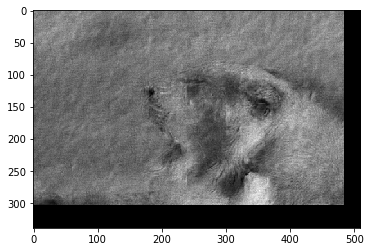

In [261]:
print_luminance(im)

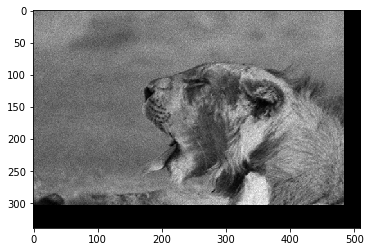

In [152]:
print_luminance(it)

In [ ]:
save_model(model, "test")